In [41]:
import numpy as np
import pandas as pd
import os
import nibabel as nb
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path

import src.freesurfer_utils as fsu



## Test load

In [34]:
subjects_dir = "/Users/benparker/Desktop/cnl/neurocluster/HCP/subjects"
brain = nb.load(f"{subjects_dir}/100307/mri/orig.mgz")


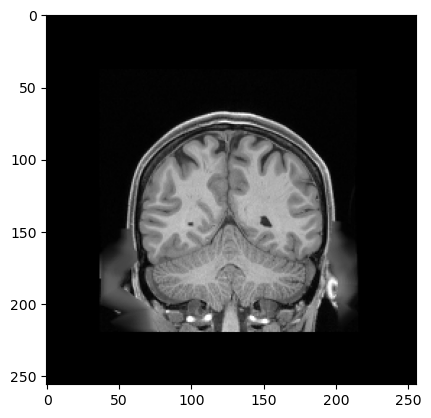

In [35]:
bdata = brain.get_fdata()
plt.imshow(bdata[:,:,100].T, cmap='gray')

In [37]:
annot = nb.load(f'{subjects_dir}/100307/mri/lh.PFC_LPC_PMC.nii.gz')
annot = annot.get_fdata()

In [38]:
np.unique(annot)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47.])

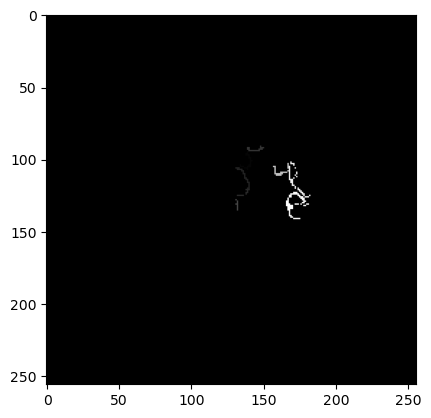

In [39]:
plt.imshow(annot[:,:,100].T, cmap='gray')

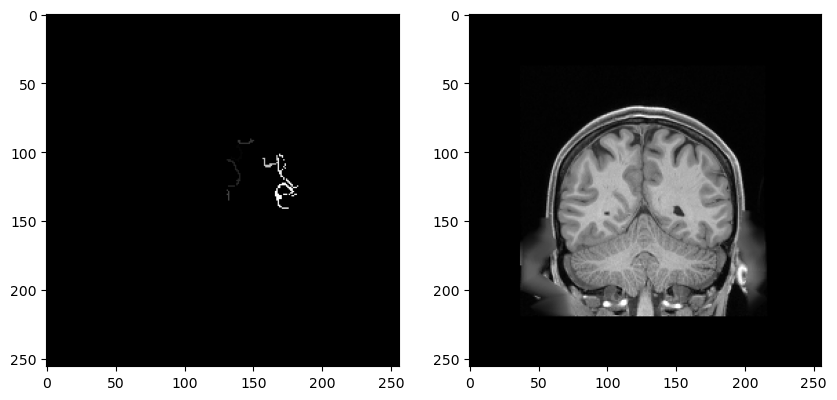

In [63]:
stacked = np.stack([bdata, annot])
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(stacked[1,:,:,100].T, cmap='gray');
ax[1].imshow(stacked[0,:,:,100].T, cmap='gray');

## Load all subjects

In [48]:
subjects_paths = fsu.get_subjects_list(subjects_list = f"{subjects_dir}/../subject_lists/HCP_processed_subs_all.txt",
                                 subjects_dir = subjects_dir)

subjects = [i[-6:] for i in subjects_paths]

data_dict = {}

for subject in subjects:
    data_dict[subject] = [
        nb.load(f"{subjects_dir}/{subject}/mri/brain.mgz").get_fdata(),
        nb.load(f"{subjects_dir}/{subject}/mri/lh.PFC_LPC_PMC.nii.gz").get_fdata(),
        nb.load(f"{subjects_dir}/{subject}/mri/rh.PFC_LPC_PMC.nii.gz").get_fdata(),
    ]

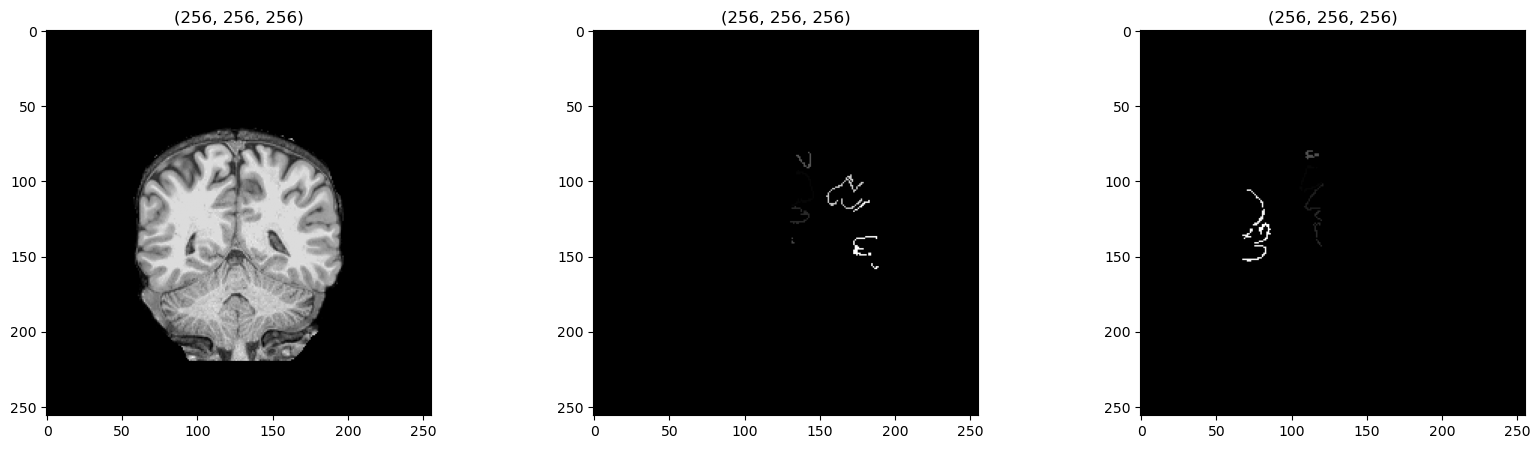

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i in range(3):  
    ax[i].imshow(data_dict['100206'][i][:,:,100].T, cmap='gray')
    ax[i].set_title(data_dict['100206'][i].shape)
plt.show()


In [79]:
np.unique(data_dict['100206'][1])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48.])

In [80]:
np.unique(data_dict['100206'][2])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45.])